In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/instagram-analytics-dataset/Instagram_Analytics.csv


     post_id                 upload_date media_type   likes  comments  shares  \
0  IG0000001  2024-11-30 09:25:22.954916       Reel   31627      7559    4530   
1  IG0000002  2025-08-15 09:25:22.954916      Photo   63206      3490    1680   
2  IG0000003  2025-09-11 09:25:22.954916       Reel   94373      3727    1761   
3  IG0000004  2025-09-18 09:25:22.954916       Reel  172053      7222    2875   
4  IG0000005  2025-03-21 09:25:22.954916      Video   99646      2703    4444   

   saves    reach  impressions  caption_length  hashtags_count  \
0   6393   615036      1007750            1340               3   
1   6809  1237071      1345900            1351              20   
2   8367  1127470      1305369             242              24   
3   9290   764030       897874             446              11   
4   9746     7004       495406            1905               8   

   followers_gained traffic_source  engagement_rate content_category  
0               899      Home Feed           

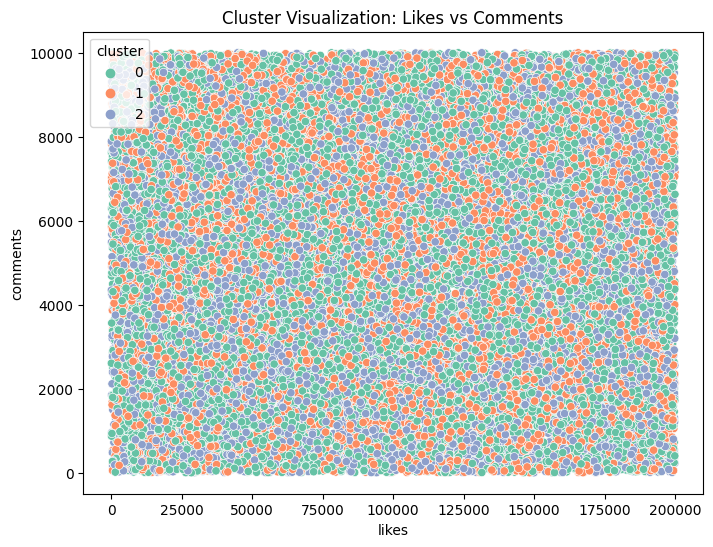

Classification Report:

              precision    recall  f1-score   support

           0       0.51      0.51      0.51      2990
           1       0.51      0.51      0.51      3010

    accuracy                           0.51      6000
   macro avg       0.51      0.51      0.51      6000
weighted avg       0.51      0.51      0.51      6000

Regression R²: -0.0007523251041230417
Regression RMSE: 49.72865515168658


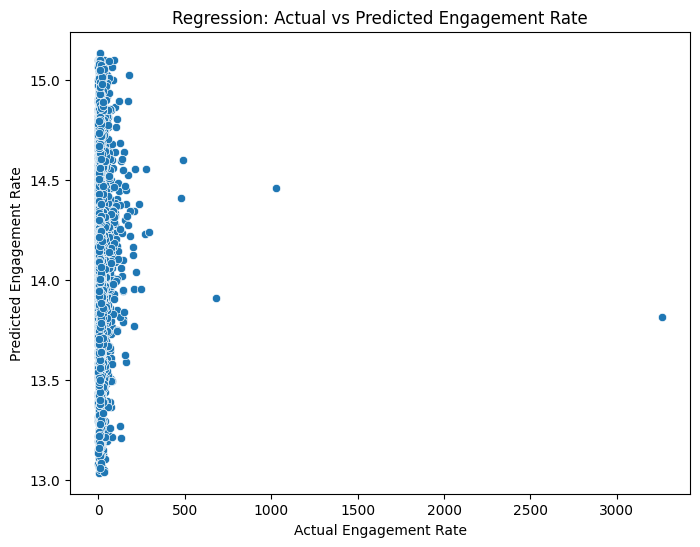

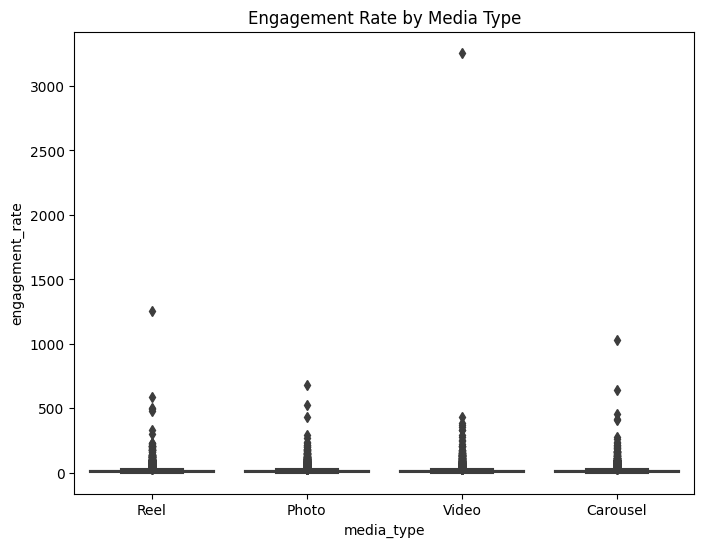

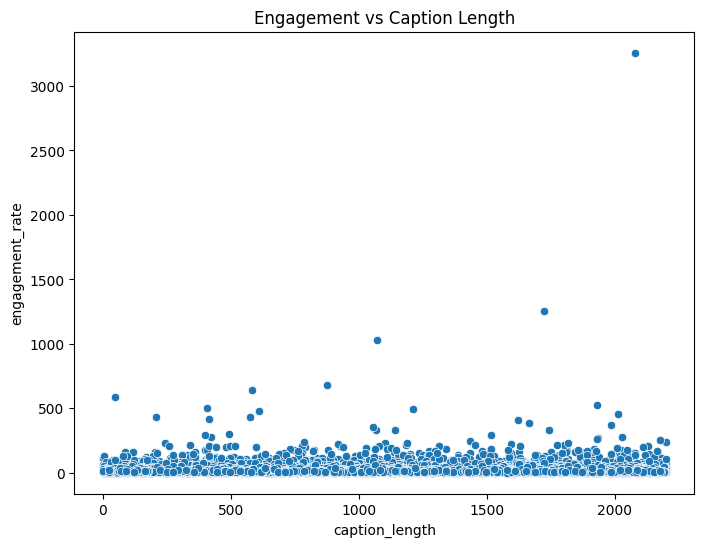

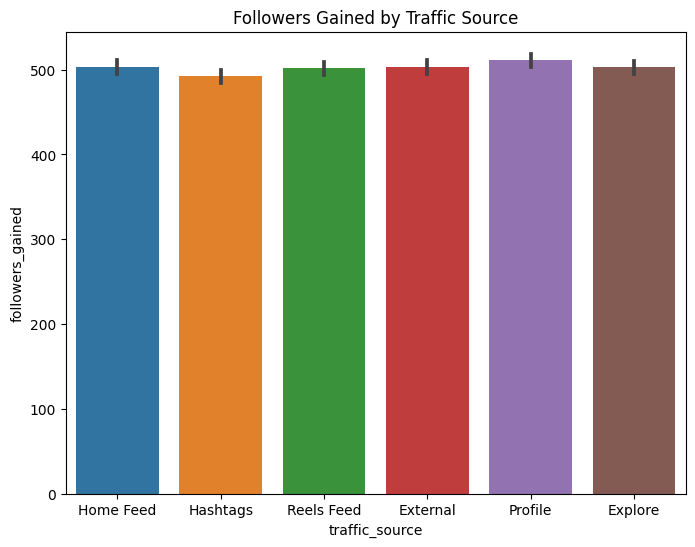

Project completed: Results saved to 'instagram_analysis_results.csv'.


In [13]:
# =========================================
# Instagram Analytics Project: Modeling
# Clustering, Classification, Regression, Evaluation
# =========================================

#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, mean_squared_error, r2_score, silhouette_score

# -----------------------------
# Load Dataset
# -----------------------------
csv_path = '/kaggle/input/instagram-analytics-dataset/Instagram_Analytics.csv'
df = pd.read_csv(csv_path)

print(df.head())
print(df.info())
print(df.describe())

# -----------------------------
# Data Cleaning / Preprocessing
# -----------------------------
df['upload_date'] = pd.to_datetime(df['upload_date'])
df.fillna({'shares': 0, 'saves': 0}, inplace=True)

categorical_cols = ['media_type', 'traffic_source']
for col in categorical_cols:
    df[col] = df[col].astype('category')

# Feature engineering: engagement rate
if 'engagement_rate' not in df.columns:
    df['engagement_rate'] = (df['likes'] + df['comments'] + df['shares'] + df['saves']) / df['impressions']

# -----------------------------
# Clustering
# -----------------------------
features_cluster = df[['likes', 'comments', 'shares', 'saves', 'reach', 'impressions']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_cluster)

# Explicit n_init
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

score = silhouette_score(X_scaled, df['cluster'])
print(f'Silhouette Score: {score:.3f}')

plt.figure(figsize=(8,6))
sns.scatterplot(x='likes', y='comments', hue='cluster', data=df, palette='Set2')
plt.title('Cluster Visualization: Likes vs Comments')
plt.show()

# -----------------------------
# Classification
# -----------------------------
threshold = df['engagement_rate'].median()
df['high_engagement'] = (df['engagement_rate'] > threshold).astype(int)

X_cls = pd.get_dummies(df[['media_type', 'caption_length', 'hashtags_count', 'traffic_source']], drop_first=True)
y_cls = df['high_engagement']

X_train, X_test, y_train, y_test = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# -----------------------------
# Regression
# -----------------------------
X_reg = X_cls
y_reg = df['engagement_rate']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

reg = LinearRegression()
reg.fit(X_train_r, y_train_r)
y_pred_r = reg.predict(X_test_r)

print('Regression R²:', r2_score(y_test_r, y_pred_r))
print('Regression RMSE:', mean_squared_error(y_test_r, y_pred_r, squared=False))

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_r, y=y_pred_r)
plt.xlabel('Actual Engagement Rate')
plt.ylabel('Predicted Engagement Rate')
plt.title('Regression: Actual vs Predicted Engagement Rate')
plt.show()

# -----------------------------
# Insights and Communication
# -----------------------------
# Boxplot: Engagement by media type 
plt.figure(figsize=(8,6))
sns.boxplot(x=df['media_type'].astype(str), y='engagement_rate', data=df)
plt.title('Engagement Rate by Media Type')
plt.show()

# Scatter: Caption length vs Engagement
plt.figure(figsize=(8,6))
sns.scatterplot(x='caption_length', y='engagement_rate', data=df)
plt.title('Engagement vs Caption Length')
plt.show()

# Barplot: Followers gained by traffic source
plt.figure(figsize=(8,6))
sns.barplot(x=df['traffic_source'].astype(str), y='followers_gained', data=df)
plt.title('Followers Gained by Traffic Source')
plt.show()

# -----------------------------
# Save Results
# -----------------------------
df.to_csv('instagram_analysis_results.csv', index=False)
print("Project completed: Results saved to 'instagram_analysis_results.csv'.")
